GulonCV Simple Pose on Amazon SageMaker
===================================================================
---

*Credits*: the Simple Pose training scripts used in this notebook were adapted from [GluonCV](https://gluon-cv.mxnet.io/model_zoo/pose.html#simple-pose-with-resnet).


We'll need to install some dependencies that might not be included in your MXNet environment.

**Learning Objectives:**

* How to train and deploy a GluonCV Pose Estimation Model on Amazon SageMaker
* How to deploy an inference pipeline model to process images using multiple Computer Vision models.


---

<img src= https://dtong-ml-datasets.s3.amazonaws.com/web/images/pose-estim-dancing.gif width=50% align="center"/>

Prepare our Development Environment
==============================

MXNet Kernels



In [1]:
!pip install --upgrade pip
!pip install matplotlib

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages (20.2.2)


In [2]:
%matplotlib inline

In [19]:
from __future__ import division

import time, os
from datetime import datetime

import boto3

import numpy as np
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.data.vision import transforms

import sagemaker

from sagemaker.mxnet import MXNet, MXNetModel
from sagemaker.pipeline import PipelineModel

# This notebook will only run on MXNet version >= 1.6.0. The GluonCV pose estimation script
# is dependent on MXNet >= 1.6.0 and GluonCV >= 0.8.0
FRAMEWORK_VERSION = "1.6.0"
PYTHON_VERSION = "py3"
SOURCE_DIR = '../scripts/simple-pose'

runtime = boto3.client(service_name='runtime.sagemaker')
sagemaker_client = boto3.client('sagemaker')

session = sagemaker.Session()
role = sagemaker.get_execution_role()

GluonCV isn't pre-installed into this environment. However, most of the dependencies required by GluonCV have already been packaged into the conda_mxnet_p36 environment.

This notebook has requirements that we will have to install manually:

MXNet 1.6+
GluonCV libraries
Installation instructions for GluonCV are provided here

MXNet dependencies are GPU dependent, so we'll check for the presence of GPU devnices first.

---
MXNet dependencies are GPU dependent, so we'll check for the presence of GPU devnices first.

In [4]:
USE_GPU = True
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = mx.gpu(0)
    print('GPU device is available')
except:
    ctx = mx.cpu()
    USE_GPU = False
    print('Using CPU on local machine. GPU device was not detected')

GPU device is available


---
GPU device is available
Next we...

Upgrade MXNet 1.6 for CUDA 10.1 with the appropriate libraries depending on whether GPU is available.
Install GluonCV
---

In [10]:
GLUONCV_COMPATIBILITY = {
    "1.5.0":"0.6.0",
    "1.5.1":"0.6.0",
    "1.6.0":"0.8.0"
}
start = time.time()

if mx.__version__ < FRAMEWORK_VERSION : 
    if USE_GPU :
        cmd = 'pip install mxnet-cu101mkl=={} --upgrade'.format(FRAMEWORK_VERSION)
    else :
        cmd ='pip install mxnet-mkl=={} --upgrade'.format(FRAMEWORK_VERSION)

    print("Changing MXNet: {}".format(cmd))
    os.system(cmd)

cmd = "pip install gluoncv=={} --upgrade".format(GLUONCV_COMPATIBILITY[FRAMEWORK_VERSION])
print("Install GluonCV: {}".format(cmd))
os.system(cmd)

end = time.time()

print("GluonCV dependencies were installed in {:3f} seconds.".format(end-start))

Install GluonCV: pip install gluoncv==0.8.0 --upgrade
GluonCV dependencies were installed in 2.575705 seconds.


Prepare COCO datasets
==============================

<img src=http://cocodataset.org/images/coco-logo.png width=20% align="left"/>

[COCO](<http://cocodataset.org/#home>) is a large-scale object detection, segmentation, and captioning datasetself. It contains annotations for keypoints, which can be used for training pose estimation.

The dataset is large. We'll download a partial dataset for learning purposes.

---

We need to transfer the dataset to S3, so that our SageMaker Training job can access the data. Provide a S3 bucket URI for us to save the data.

In [7]:
##eg. s3://dtongma-ml-datasets-us-west-2/pose-estimation-workshop/coco/sample
#TRAINING_DATA = '<<YOUR BUCKET>>'
TRAINING_DATA = 's3://dtongma-ml-datasets-us-west-2/pose-estimation-workshop/coco/sample2'

DOWNLOAD_SCRIPT = "../utils/dl_coco_partial.py"
DOWNLOAD_DIR = "../datasets/coco"

Run the cell below to download a partial dataset and transfer it to your bucket. This will take 5-10 minutes.

In [8]:
start = time.time()

os.system("python {} --download-dir {}".format(DOWNLOAD_SCRIPT, DOWNLOAD_DIR))

#we're using the validation set for learning purposes. It's manageable at 1/10th the size of the training set.
os.system("aws s3 sync {} {}".format(os.path.join(DOWNLOAD_DIR,"val2017"), 
                                      os.path.join(TRAINING_DATA,"val2017")))
           
os.system("aws s3 cp {} {}".format(os.path.join(DOWNLOAD_DIR,"annotations","person_keypoints_val2017.json"), 
                                      os.path.join(TRAINING_DATA,"annotations","person_keypoints_train2017.json")))
          
end = time.time()

print("Transferred partial COCO dataset in {:3f} seconds.".format(end-start))

Transferred partial COCO dataset in 140.351032 seconds.


Model Training
==============================

### Local Prototyping
---

Run locally...

In [47]:
!mkdir ./models/simple-pose
!python $SOURCE_DIR/simple-pose-train.py \
--model-dir ./models/simple-pose \
--train ../datasets/coco \
--lr 0.000001 \
--num-joints 17 \
--use-pretrained True \
--local True \
--model simple_pose_resnet18_v1b \
--num-gpus 1 \
--num-workers 1 \
--save-format $MX_MODE \
--batch-size 4 --num-epochs 1 --mode hybrid

mkdir: cannot create directory ‘./models/simple-pose’: File exists
Namespace(batch_size=8, dtype='float32', input_size='256,192', last_gamma=False, local=True, log_interval=20, logging_file='keypoints.log', lr=1e-06, lr_decay=0.1, lr_decay_epoch='40,60', lr_decay_period=0, lr_mode='step', mean='0.485,0.456,0.406', mode='hybrid', model='simple_pose_resnet18_v1b', model_dir='./models/simple-pose', no_wd=False, num_epochs=1, num_gpus=1, num_joints=17, num_workers=4, save_dir='params', save_format='symbolic', save_frequency=1, save_prefix='', sigma=2, std='0.229,0.224,0.225', train='../datasets/coco', use_pretrained=True, use_pretrained_base=False, val=None, warmup_epochs=0, warmup_lr=0.0, wd=0.0001)
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv1b_conv0_weight' is already initialized, ignoring. Set force_reinit=True 

## Scale Training

### Installing Dependencies on SageMaker Managed Containers

---

One of the main benefits of leveraging the "Bring-Your-Own-Script" (BYOS) integration strategy is that it reduces alot of heavy-lifting compared to the alternative. For instance, if you want to integrate a custom algorithm in R with Amazon SageMaker, it is feasible. However, at this point in time, the BYOS integration option doesn't supported in R. Integrating your R algorithm would require you to build  an Amazon SageMaker compatible container to house your custom [algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms.html).

MXNet, however, supports BYOS--Amazon SageMaker provides and maintains MXNet containers natively. However, in cases like the one in this lab, we may want to install or upgrade select depedencies. You have the option of creating your own SageMaker compatible container and use the MXNet container as a base, or update the dependencies at launch time using [requirements.txt](https://pip.pypa.io/en/stable/user_guide/#id15).

DevOps best practices recommend building your own container. Requirements.txt is often ideal for development. You can apply minor updates quickly to support rapid prototyping.

---
Below are some helper scripts to set requirements.txt for your target environment and also provide suggestions for GPU dependent configurations.

In [24]:
# sample selection of SageMaker instances and available GPUs
INSTANCE_GPUS = {
    'ml.p3.2xlarge':1,
    'ml.p3.8xlarge':4,
    'ml.c5.4xlarge':0,
    'ml.c5.2xlarge':0,
    'ml.c5.xlarge':0,
    'ml.g4dn.xlarge':1
}

def set_requirements_text(gpu_train=True, framework_v=FRAMEWORK_VERSION) :
    
    req_file = "{}/requirements.txt".format(SOURCE_DIR)
    with open(req_file, "r+") as f:
        data = f.read()
        f.seek(0)
        f.write("gluoncv=={} \n".format(GLUONCV_COMPATIBILITY[framework_v]))
        f.write("opencv-python==3.3.0.9")
        f.truncate()
        
    !pygmentize $SOURCE_DIR/requirements.txt

def environment_device_config(instance_selection, acceleration_type=None, framework_v=FRAMEWORK_VERSION) :
    
    USE_GPU = (INSTANCE_GPUS[instance_selection] > 0)

    n_gpus = INSTANCE_GPUS[instance_selection]

    print('Set requirements.txt:') 
    print('-----------------------------------')
    set_requirements_text(USE_GPU,framework_v)
    print('-----------------------------------')
    
    config={
        "num_gpus":n_gpus,
        "batch_size_range": [1 if USE_GPU else 1, 16 if USE_GPU else 64]
    }
    
    print('You have selected {}{}, which will utilize {}.'.format(instance_selection, 
                                                                '' if acceleration_type == None else " with EIA ({})".format(acceleration_type),
                                                                'GPU' if USE_GPU else 'CPU' if acceleration_type == None else "EIA"))
    
    print('Recommended training configurations: {}'.format(config))
    
    return config

In [16]:
INSTANCE_SELECTION = 'ml.p3.2xlarge'
config = environment_device_config(INSTANCE_SELECTION)

BASE_JOB_NAME='dylantong-pose-training'
NUM_JOINTS = 17
MX_MODE = "symbolic"

params = {
    'lr': 0.000001, 
    'num-joints': NUM_JOINTS, 
    'use-pretrained': True,
    'num-epochs': 1,
    'model': 'simple_pose_resnet18_v1b',
    'num-gpus' : config["num_gpus"],
    'batch-size' : int(config["batch_size_range"][1]/2),
    'mode': 'hybrid',
    'save-format': MX_MODE,
    'j': 3
}

print()
print("Using params: {}".format(params))

Set requirements.txt for GPU:
-----------------------------------
gluoncv==0.8.0 
opencv-python==3.3.0.9
-----------------------------------
You have selected ml.p3.2xlarge, which will utilize GPU.
Recommended configurations: {'num_gpus': 1, 'batch_size_range': [1, 16]}

Using params: {'lr': 1e-06, 'num-joints': 17, 'use-pretrained': True, 'num-epochs': 1, 'model': 'simple_pose_resnet18_v1b', 'num-gpus': 1, 'batch-size': 8, 'mode': 'hybrid', 'save-format': 'symbolic', 'j': 3}


Configure our estimator for remote training...

In [20]:
pose_estimator = MXNet(entry_point='simple-pose-train.py',
                        role=role,
                        source_dir=SOURCE_DIR,
                        framework_version=FRAMEWORK_VERSION,
                        py_version=PYTHON_VERSION,
                        train_instance_count=1,
                        train_instance_type=INSTANCE_SELECTION,
                        sagemaker_session=sagemaker.Session(),
                        base_job_name=BASE_JOB_NAME,
                        hyperparameters=params)

Perform model training...

In [21]:
pose_estimator.fit({'train':TRAINING_DATA})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-30 23:13:01 Starting - Starting the training job...
2020-08-30 23:13:04 Starting - Launching requested ML instances......
2020-08-30 23:14:14 Starting - Preparing the instances for training......
2020-08-30 23:15:17 Downloading - Downloading input data.........
2020-08-30 23:16:56 Training - Training image download completed. Training in progress..2020-08-30 23:16:56,080 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2020-08-30 23:16:56,104 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":8,"j":3,"lr":1e-06,"mode":"hybrid","model":"simple_pose_resnet18_v1b","num-epochs":1,"num-gpus":1,"num-joints":17,"save-format":"symbolic","use-pretrained":true}', 'SM_USER_ENTRY_POINT': 'simple-pose-train.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', '

Model Serving
==============================
---

dfasfa

In [22]:
!pygmentize $SOURCE_DIR/'simple-pose-inference.py'

import os
import json
import sys, logging

import numpy as np
import mxnet as mx
from mxnet import gluon

from gluoncv import model_zoo, data
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

logger = logging.getLogger('')
    
def load_imperative_model(model_dir, device) :
        
    kwargs = {'ctx': device, 
              'num_joints': 17,
              'pretrained': False,
              'pretrained_base': False,
              'pretrained_ctx': device}
    
    base, w = get_model_info(model_dir)
    net = model_zoo.get_model('simple_pose_resnet18_v1b', **kwargs)
    net.load_parameters(os.path.join(model_dir,w))
    
    return net

def load_sym_model(sym_f, param_f, model_dir, device) :

    sym_file = os.path.join(model_dir, sym_f)
    param_file = os.path.join(model_dir, param_f)
    
    return gluon.nn.SymbolBlock.imports(sym_file, ['data'], param_file, ctx=device)
       
def model_fn(model_dir):
    
    try:
        if os.environ['USE_EIA'

In [28]:
# 8/28/2020 MXNET 1.6 containers don't have support for elastic inference. Using MXNet 1.5.1 for serving temporarily.
#INFERENCE_MXNET_VER = '1.5.1'
#ACCELERATION_TYPE = 'ml.eia1.medium'
INFERENCE_MXNET_VER = '1.6.0'
ACCELERATION_TYPE = None

INSTANCE_SELECTION = 'ml.c5.4xlarge'
#INSTANCE_SELECTION = 'ml.p3.2xlarge'

config = environment_device_config(INSTANCE_SELECTION, ACCELERATION_TYPE, INFERENCE_MXNET_VER)

USE_GPU = config['num_gpus'] > 0
USE_EIA = (ACCELERATION_TYPE is not None) and not USE_GPU

IMG_WIDTH = 512
#IMG_WIDTH = 180

MX_MODE = "symbolic"
SYM_FILE_NAME = "simple-pose-gcv-symbol.json"
PARAM_FILE_NAME = "simple-pose-gcv-0000.params"



Set requirements.txt:
-----------------------------------
gluoncv==0.8.0 
opencv-python==3.3.0.9
-----------------------------------
You have selected ml.c5.4xlarge, which will utilize CPU.
Recommended training configurations: {'num_gpus': 0, 'batch_size_range': [1, 64]}


---

safasf

In [29]:
env_vars = {"SAGEMAKER_MODEL_SERVER_TIMEOUT":"3600",
            "USE_GPU": str(int(USE_GPU)),
            "USE_EIA": str(int(USE_EIA)),
            "IMG_WIDTH": str(IMG_WIDTH)}

yolo_model = MXNetModel(model_data = "s3://dtong-public-fileshare/models/yolov3/symbolic/model.tar.gz",
                        role=role,
                        framework_version=INFERENCE_MXNET_VER,
                        py_version=PYTHON_VERSION,
                        entry_point='yolov3-inference.py',
                        env = env_vars,
                        source_dir=SOURCE_DIR)

yolo_model.sagemaker_session = session
container_def = yolo_model.prepare_container_def(instance_type=INSTANCE_SELECTION)
session.create_model("pose-estimator-pipeline-yolov3", role, container_def)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Using already existing model: pose-estimator-pipeline-yolov3


'pose-estimator-pipeline-yolov3'

---

dfasdfas

In [30]:
env_vars = {"SAGEMAKER_MODEL_SERVER_TIMEOUT":"3600",
            "SYM_FILE_NAME":SYM_FILE_NAME,
            "PARAM_FILE_NAME":PARAM_FILE_NAME,
            "MX_MODE": MX_MODE,
            "USE_GPU": str(int(USE_GPU)),
            "USE_EIA": str(int(USE_EIA)),
            "IMG_WIDTH": str(IMG_WIDTH)}
                              
pose_model = MXNetModel(model_data = pose_estimator.model_data,
                        role=role,
                        framework_version=INFERENCE_MXNET_VER,
                        py_version=PYTHON_VERSION,
                        entry_point='simple-pose-inference.py',
                        env = env_vars,
                        source_dir=SOURCE_DIR)

pose_model.sagemaker_session = session
container_def = pose_model.prepare_container_def(instance_type=INSTANCE_SELECTION)
session.create_model("pose-estimator-pipeline-simple-pose", role, container_def)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Using already existing model: pose-estimator-pipeline-simple-pose


'pose-estimator-pipeline-simple-pose'

---

asdfa

In [31]:
pose_inf_pipeline = PipelineModel(name='pose-inf-pipeline',
                                  role=role,
                                  sagemaker_session=session,
                                  models=[yolo_model, pose_model])

In [ ]:
RT_PIPELINE_EP_NAME = 'dylantong-pose-inf-ep-{}'.format(datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))
#RT_ENDPOINT_NAME = '<<PROVIDE AN ENDPOINT NAME>>'
print('endpoint name: {}'.format(RT_PIPELINE_EP_NAME))

start = time.time()
pose_pipe_ep = pose_inf_pipeline.deploy(instance_type=INSTANCE_SELECTION,
                                        initial_instance_count = 1,
                                        endpoint_name= RT_PIPELINE_EP_NAME)
end = time.time()

print("Endpoint was deployed in {:3f} seconds.".format(end-start))

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


endpoint name: dylantong-pose-inf-ep-2020-08-30-23-42-54


'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Using already existing model: pose-inf-pipeline


-------

Test our Model
==============================
---



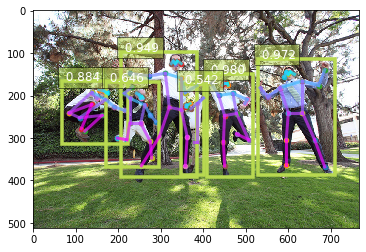

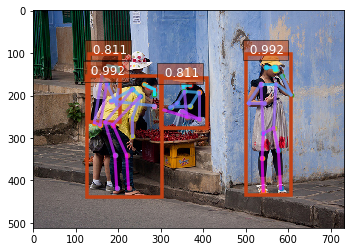

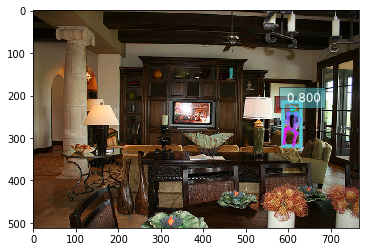

In [311]:
CID_END_OFFSET = 100
SCORE_END_OFFSET = 200
BBOX_END_OFFSET = 600
Y = 100
N_SCORES = 1
N_CID = 1
N_BBOX_POINTS = 4

JOINTS = 17
IMG_DIMS = 2

USE_GPU = 0
USE_EIA = 0

def generate_request_payload(img_loc) :

    with open(img_loc, 'rb') as image:
        f = image.read()
        b = bytearray(f)
        
    return b

def parse_response_payload(resp) :
    
    stacked_tensors = np.frombuffer(resp, dtype="float32")
    t= np.split(stacked_tensors,[CID_END_OFFSET,SCORE_END_OFFSET,BBOX_END_OFFSET])

    cid= mx.nd.array(t[0].reshape(1,Y,N_SCORES))
    s= mx.nd.array(t[1].reshape(1,Y,N_CID))
    bb= mx.nd.array(t[2].reshape(1,Y,N_BBOX_POINTS))
    
    pose_data_size = int(t[3].shape[0])
    split = int(pose_data_size*2/3)
    
    kp = t[3][0:split].reshape(-1,JOINTS,IMG_DIMS)
    s2= t[3][split:pose_data_size].reshape(-1,JOINTS,1)

    return (cid,s,bb,kp,s2)

IMGS = ['val2017/000000296657.jpg','val2017/000000323263.jpg','val2017/000000440475.jpg']

def test_endpoint(img_file_list) :
    
    for img in img_file_list :

        b = generate_request_payload(os.path.join(DOWNLOAD_DIR,img))
        
        response = runtime.invoke_endpoint(EndpointName= 'dylantong-pose-inf-ep-2020-08-30-21-10-34',
                                           ContentType='image/jpeg',
                                           Body=b,
                                           Accept="application/x-npy")
        
        cid,s,bb,kp,s2 = parse_response_payload(response["Body"].read())

        x, img = data.transforms.presets.yolo.transform_test(mx.img.imdecode(b), IMG_WIDTH)
        
        ax = utils.viz.plot_keypoints(img, kp, s2,
                                      cid, bb, s,
                                      box_thresh=0.5, keypoint_thresh=0.2)
        plt.show()

        
test_endpoint(IMGS)

---

References
----------

.. [1] Xiao, Bin, Haiping Wu, and Yichen Wei. \
       "Simple baselines for human pose estimation and tracking." \
       Proceedings of the European Conference on Computer Vision (ECCV). 2018.
.. [2] https://github.com/Microsoft/human-pose-estimation.pytorch/issues/48
.. [3] https://github.com/PaddlePaddle/models/tree/develop/fluid/PaddleCV/human_pose_estimation#known-issues

